# Saliency Methods
Example usage of the saliency methods. Every saliency method is instantiated with the model (e.g., `saliency_method = XRAI(model)`). Then, it can be used to compute the attributions of a batch on inputs: `attributions = saliency_methods(input_batch)`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torch
import torchvision.models as models

from saliency_methods.util import visualize_saliency
from saliency_methods.gradcam import GradCAM
from saliency_methods.gradient_shap import GradientSHAP
from saliency_methods.guided_backprop import GuidedBackprop
from saliency_methods.input_x_gradient import InputXGradient
from saliency_methods.integrated_gradients import IntegratedGradients
from saliency_methods.kernel_shap import KernelSHAP
from saliency_methods.lime_method import LIME
from saliency_methods.rise import RISE
from saliency_methods.sis import SIS
from saliency_methods.vanilla_gradients import VanillaGradients
from saliency_methods.xrai import XRAI

## Load model and image
We load a pretrained Inception V3 from PyTorch and a sample image from disk. The saliency methods interface can take in a batch of images, so we  create a batch using transformed versions of the image. The model correctly predicts both images to be a `doberman`.

In [3]:
MODEL = models.__dict__['inception_v3'](pretrained=True).cuda().eval()

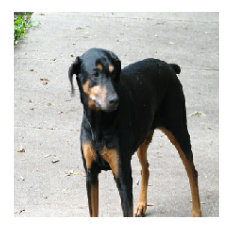

In [4]:
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    return im / 127.5 - 1.0 # normalize -1 to 1 for inception

def show_image(im, ax=None):
    if ax is None:
        _, ax = plt.subplots(nrows=1, ncols=1)
    ax.axis('off')
    im = ((im + 1) * 127.5).astype(np.uint8)
    ax.imshow(im)
    
def show_batch(batch):
    batch_size = batch.shape[0]
    fig, axes = plt.subplots(nrows=1, ncols=batch_size)
    for i, image in enumerate(batch):
        show_image(image, axes[i])
    
IMAGE = load_image('resources/doberman.png')
show_image(IMAGE)

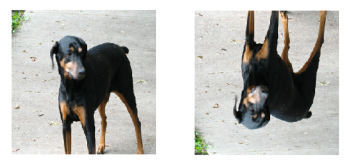

In [24]:
# Make Test Image Batch
input_instance = torch.from_numpy(IMAGE.transpose(2, 0, 1)).cuda().float()[:3, :, :]
input_instance_flipped = torch.from_numpy(np.flip(IMAGE.transpose(2, 0, 1), axis=1).copy()).cuda().float()[:3, :, :]
input_batch = torch.stack([input_instance, input_instance_flipped])
display_batch = np.array([((image + 1) * 127.5).detach().cpu().numpy().astype(np.uint8) for image in input_batch])
show_batch(input_batch.detach().cpu().numpy().transpose(0, 2, 3, 1))

In [6]:
# Predict Image Class
with open('resources/imagenet_labels.json', 'r') as f:
    labels = json.load(f)
output = MODEL(input_batch)
predictions = np.argmax(output.cpu().detach().numpy(), axis=1)
for i, prediction in enumerate(predictions):
    print('Prediction %d:' %i, prediction, labels[prediction])

Prediction 0: 236 Doberman
Prediction 1: 236 Doberman


## Run the saliency methods
We run each method on the image batch using the `get_saliency` and `get_saliency_smoothed` methods. We use different display options throughout.

### Vanilla Gradients

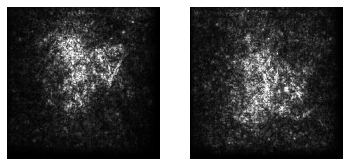

In [22]:
vanilla_gradients = VanillaGradients(MODEL)
vanilla_gradient_saliency = vanilla_gradients.get_saliency(input_batch)
visualize_saliency(vanilla_gradient_saliency);

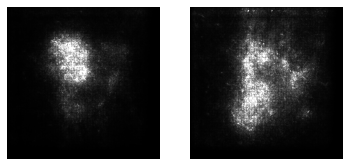

In [8]:
vanilla_gradient_smoothgrad_saliency = vanilla_gradients.get_saliency_smoothed(input_batch)
visualize_saliency(vanilla_gradient_smoothgrad_saliency);

### Integrated Gradients

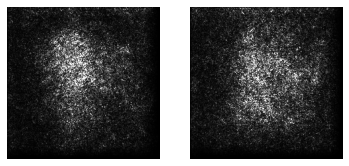

In [9]:
integrated_gradients = IntegratedGradients(MODEL)
integrated_gradient_saliency = integrated_gradients.get_saliency(input_batch)
visualize_saliency(integrated_gradient_saliency);

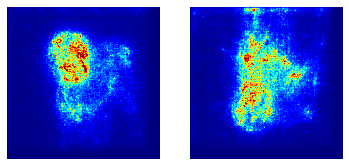

In [10]:
integrated_gradient_smoothgrad_saliency = integrated_gradients.get_saliency_smoothed(input_batch)
visualize_saliency(integrated_gradient_smoothgrad_saliency, scheme='heatmap',);

### Guided BackProp

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:61: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


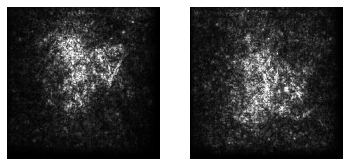

In [11]:
guided_backprop = GuidedBackprop(MODEL)
guided_backprop_saliency = guided_backprop.get_saliency(input_batch)
visualize_saliency(guided_backprop_saliency);

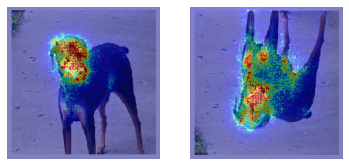

In [23]:
guided_backprop_smoothgrad_saliency = guided_backprop.get_saliency_smoothed(input_batch)
visualize_saliency(guided_backprop_smoothgrad_saliency, images=display_batch, scheme='heatmap', overlay='overlay');

### Input X Gradient

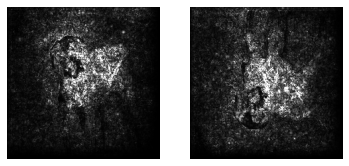

In [13]:
input_x_gradient = InputXGradient(MODEL)
input_x_gradient_saliency = input_x_gradient.get_saliency(input_batch)
visualize_saliency(input_x_gradient_saliency);

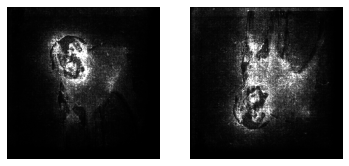

In [14]:
input_x_gradient_smoothgrad_saliency = input_x_gradient.get_saliency_smoothed(input_batch)
visualize_saliency(input_x_gradient_smoothgrad_saliency);

### GradCAM

/nobackup/users/aboggust/bin/miniconda3/envs/wml/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


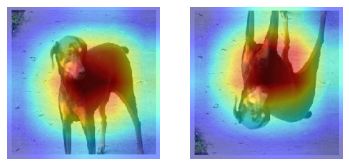

In [15]:
gradcam = GradCAM(MODEL, MODEL.Mixed_7c)
gradcam_saliency = gradcam.get_saliency(input_batch)
visualize_saliency(gradcam_saliency, images=display_batch, scheme='heatmap', overlay='overlay');

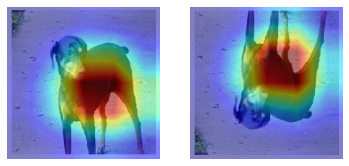

In [16]:
gradcam_smoothgrad_saliency = gradcam.get_saliency_smoothed(input_batch)
visualize_saliency(gradcam_smoothgrad_saliency, images=display_batch, scheme='heatmap', overlay='overlay');

### Gradient SHAP

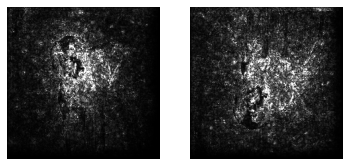

In [17]:
gradient_shap = GradientSHAP(MODEL)
gradient_shap_saliency = gradient_shap.get_saliency(input_batch)
visualize_saliency(gradient_shap_saliency);

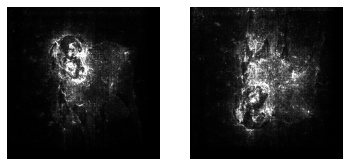

In [18]:
gradient_shap_smoothgrad_saliency = gradient_shap.get_saliency_smoothed(input_batch)
visualize_saliency(gradient_shap_smoothgrad_saliency);

### XRAI

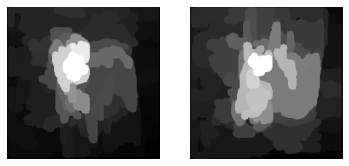

In [27]:
xrai = XRAI(MODEL)
xrai_saliency = xrai.get_saliency(input_batch)
visualize_saliency(xrai_saliency);

### LIME

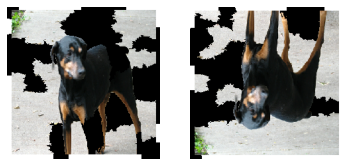

In [28]:
lime = LIME(MODEL)
lime_saliency = lime.get_saliency(input_batch)
visualize_saliency(lime_saliency, images=display_batch, overlay='mask');

### RISE

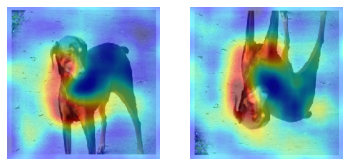

In [29]:
input_size = tuple(input_batch[0].shape)[1:]
rise = RISE(MODEL, input_size)
rise_saliency = rise.get_saliency(input_batch)
visualize_saliency(rise_saliency, images=display_batch, scheme='heatmap');

### SIS

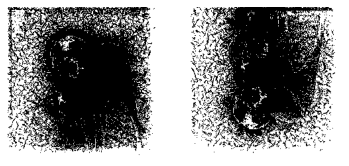

In [54]:
sis = SIS(MODEL)
sis_saliency = sis.get_saliency(input_batch, features_removed_per_iteration=1000)
visualize_saliency(sis_saliency);